# Cloud-based machine learning  || 云端机器学习

Thus far, we have looked at building and fitting ML models “locally.” True, the notebooks have been located in the cloud themselves, but the models with all of their predictive and classification power are stuck in those notebooks. To use these models, you would have to load data into your notebooks and get the results there.

到目前为止，我们已经在“本地”构建和調適機器學習模型。的确，这些notebook檔案本身已经在云端，但是所有预测和分类功能的模型也都只在这些notebook中。 要使用这些模型，您必须将数据加载到其中以获取结果。

In practice, we want those models accessible from a number of locations. And while the management of production ML models has a lifecycle all its own, one part of that is making models accessible from the web. One way to do so is to develop them using third-party cloud tools, such as [Microsoft Azure ML Studio](https://studio.azureml.net) (not to be confused with Microsoft Azure Machine Learning sService, which provides end-to-end lifecycle management for ML models).

在实际操作中，我们希望可以从多个位置取得这些模型。 尽管生产ML模型的管理具有其自己的生命周期，使模型可以从网络获取是其中一部分。使用第三方云端工具是一种开发方式，例如Microsoft Azure ML Studio。（不要与Microsoft Azure Machine Learning sService混淆，后者为ML模型提供端到端的生命周期管理）。

Alternatively, we can develop and deploy a function that can be accessed by other programs over the web—a web service—that runs within Azure ML Studio, and we can do so entirely from a Python notebook. In this section, we will use the [`azureml`](https://github.com/Azure/Azure-MachineLearning-ClientLibrary-Python) package to deploy an Azure ML web service directly from within a Python notebook (or other Python environment).

或者，我们可以开发和部署一个功能，该功能可以在Azure ML Studio中运行，并且我们可以通过Web上的其他程序通过Web服务来访问，并且可以完全通过Python notebook进行操作。 在本节中，我们将使用azureml package直接在一個Python notebook（或其他Python环境）中部署Azure ML Web服务。

> <font color=red>**Note:**</font> The `azureml` package presently works only with Python 2. If your notebook is not currently running Python 2, change it in the menu at the top of the notebook by clicking **Kernel > Change kernel > Python 2**.


> 注意：azureml软件包目前仅支持Python2。如果您的notebook当前未运行Python 2，请在上方菜单中单击进行更改
Kernel>Change Kernel> Python 2。

## Create and connect to an Azure ML Studio workspace || 创建并连接到Azure ML Studio工作区

The `azureml` package is installed by default with Azure Notebooks, so we don't have to worry about that. It uses an Azure ML Studio workspace ID and authorization token to connect your notebook to the workspace; you will obtain the ID and token by following these steps:

Azure笔记本会把Azureml软件包默认安装，它使用Azure ML Studio工作区ID和授权令牌确认将笔记本连接到工作区。遵循以下步骤，您将获取ID和令牌：

1. Open [Azure ML Studio](https://studio.azureml.net) in a new browser tab and sign in with a Microsoft account. Azure ML Studio is free and does not require an Azure subscription. Once signed in with your Microsoft account (the same credentials you’ve used for Azure Notebooks), you're in your “workspace.”

    在新的浏览器选项标签中打开Azure ML Studio，然后使用Microsoft帐户登录。 Azure ML Studio是免费的，不用认购就能使用。 使用Microsoft帐户（与Azure notebook使用的凭证相同）登录后，就可进入“工作区”。
    
    
2. On the left pane, click **Settings**.

    在左窗格中单击设置。

    ![Settings button](https://github.com/Microsoft/AzureNotebooks/blob/master/Samples/images/azure-ml-studio-settings.png?raw=true)<br/><br/>
    

3. On the **Name** tab, the **Workspace ID** field contains your workspace ID. Copy that ID into the `workspace_id` value in the code cell in Step 5 of the notebook below.
    
    在``名称''选项标签上的``工作区ID''字段上有您的工作区ID。 将该ID复制到下面第5步代码单元中的workspace_id值。

    ![Location of workspace ID](https://github.com/Microsoft/AzureNotebooks/blob/master/Samples/images/azure-ml-studio-workspace-id.png?raw=true)<br/><br/>
    

4. Click the **Authorization Tokens** tab, and then copy either token into the `authorization_token` value in the code cell in Step 5 of the notebook.

    单击“授权token”选项，然后复制任一token至第5步代码单元中的authorization_token”值中。

    ![Location of authorization token](https://github.com/Microsoft/AzureNotebooks/blob/master/Samples/images/azure-ml-studio-tokens.png?raw=true)<br/><br/>
    

5.	Run the code cell below; if it runs without error, you're ready to continue.
    运行下面的代码单元； 如果没有错误可继续运行。

In [36]:
from azureml import Workspace

# Replace the values with those from your own Azure ML Studio instance; see Prerequisites
# The workspace_id is a string of hexadecimal characters; the token is a long string of random characters.

# 将值替换为您自己的Azure ML Studio实例中的值； 请参阅前提条件(Prerequisites)
# workspace_id是十六进制字符的字符串； token是一长串随机字符。

workspace_id = 'deff291c5b7b42f1b5fdc60669aa8f8b'
authorization_token = 'token'

ws = Workspace(workspace_id, authorization_token)

## Explore forest fire data

Let’s look at a meteorological dataset collected by Cortez and Morais for 2007 to study the burned area of forest fires in the northeast region of Portugal.

让我们看一下由Cortez和Morais于2007年收集到的气象数据集，研究的是葡萄牙东北部森林大火燃烧面积

> P. Cortez and A. Morais. A Data Mining Approach to Predict Forest Fires using Meteorological Data. 
  In J. Neves, M. F. Santos and J. Machado Eds., New Trends in Artificial Intelligence, 
  Proceedings of the 13th EPIA 2007 - Portuguese Conference on Artificial Intelligence, December, 
  Guimaraes, Portugal, pp. 512-523, 2007. APPIA, ISBN-13 978-989-95618-0-9. 
 
> P. Cortez和A. Morais。一种使用气象数据预测森林火灾的数据挖掘方法。。 参见J. Neves，MF Santos和J. Machado编辑，《人工智能的新趋势》，第13届EPIA大会论文集-葡萄牙人工智能会议，12月，葡萄牙吉马良斯，第512-523页，2007年。APPIA，ISBN -13 978-989-95618-0-9。


The dataset contains the following features:

数据集包含以下特征：

- **`X`**: x-axis spatial coordinate within the Montesinho park map: 1 to 9
- **`Y`**: y-axis spatial coordinate within the Montesinho park map: 2 to 9
- **`month`**: month of the year: "1" to "12" jan-dec
- **`day`**: day of the week: "1" to "7" sun-sat
- **`FFMC`**: FFMC index from the FWI system: 18.7 to 96.20
- **`DMC`**: DMC index from the FWI system: 1.1 to 291.3 
- **`DC`**: DC index from the FWI system: 7.9 to 860.6 
- **`ISI`**: ISI index from the FWI system: 0.0 to 56.10
- **`temp`**: temperature in Celsius degrees: 2.2 to 33.30
- **`RH`**: relative humidity in %: 15.0 to 100
- **`wind`**: wind speed in km/h: 0.40 to 9.40 
- **`rain`**: outside rain in mm/m2 : 0.0 to 6.4 
- **`area`**: the burned area of the forest (in ha): 0.00 to 1090.84 


- X：Montesinho公园地图内的x轴空间坐标：1到9

- Y：Montesinho公园地图内的y轴空间坐标：2到9

- month：一年中的月份：“ 1”至“ 12” 指一月至十二月

- 日期：一星期的天數：“ 1”至“ 7”指星期一至星期日

- FFMC：FWI系统中的FFMC指数：18.7至96.20

- DMC：来自FWI系统的DMC指数：1.1至291.3

- DC：FWI系统中的DC指数：7.9至860.6

- ISI：FWI系统中的ISI指数：0.0至56.10

- temp：摄氏温度：2.2至33.30

- RH：相对湿度（％）：15.0至100

- 风：以km / h为单位的风速：0.40至9.40

- 雨水：室外雨水（mm / m2）：0.0至6.4

- 面积：森林被烧毁的面积（公顷）：0.00至1090.84


Let's load the dataset and visualize the area that was burned in relation to the temperature in that region.

让我们加载数据集，并可视化区域温度与燃烧区域的关系。


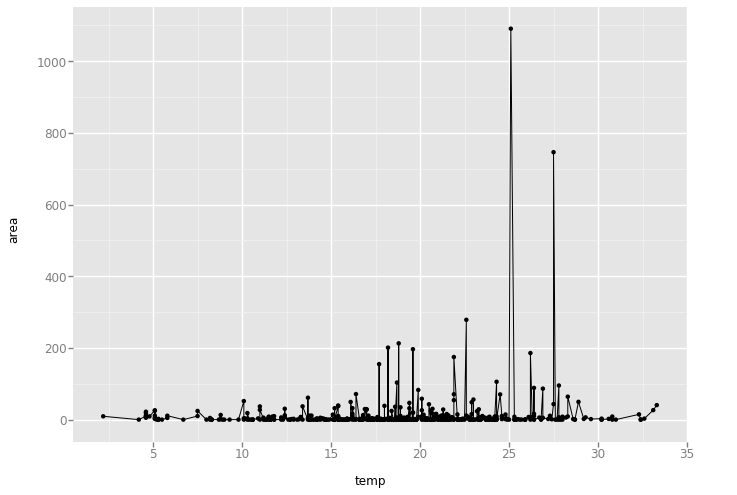

<ggplot: (8752429244005)>

In [2]:
import pandas as pd
df = pd.DataFrame(pd.read_csv('./Data/forestfires.csv'))
%matplotlib inline
from ggplot import *
ggplot(aes(x='temp', y='area'), data=df) +  geom_line() + geom_point()

Intuitively, the hotter the weather, the more hectares burned in forest fires.

直观地说，天气越热，森林大火烧毁的公顷数就越多。

## Transfer your data to Azure ML Studio

We have our data, but how do we get it into Azure ML Studio in order to use it there? That is where the `azureml` package comes in. It enables us to load data and models into Azure ML Studio from an Azure Notebook (or any Python environment).

我们有我们的数据，但是我们如何将其放入Azure ML Studio以便在那里使用？这就是“azureml”包的好处。它使我们能够从Azure笔记本（或任何Python环境）将数据和模型加载到Azure ML Studio中。

The first code cell of this notebook is what establishes the connection with *your* Azure ML Studio account.

此笔记本的第一个代码单元是与*您的*Azure ML Studio帐户建立连接。

Now that you have your notebook talking to Azure ML Studio, you can export your data to it:
现在您的笔记本已经与Azure ML Studio进行了对话，您可以将数据导出到云端：

In [3]:
# from azureml import DataTypeIds

# dataset = ws.datasets.add_from_dataframe(
#               dataframe=df,
#               data_type_id=DataTypeIds.GenericCSV,
#               name='Forest Fire Data 2',
#               description='Paulo Cortez and Aníbal Morais (Univ. Minho) @ 2007'
#           )

After running the code above, you can see the dataset listed in the **Datasets** section of the Azure Machine Learning Studio workspace. (**Note**: You might need to switch between browser tabs and refresh the page in order to see the dataset.)

运行上述代码后，您可以在Azure Machine Learning Studio工作区的**数据集**部分中看到列出的数据集

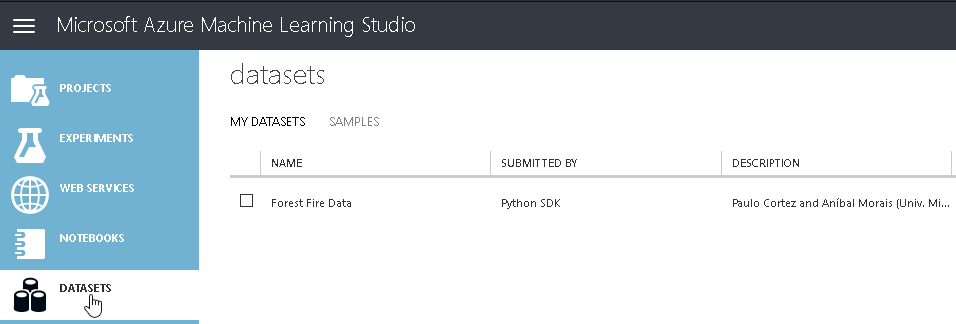<br/>

It is also straightforward to list the datasets available in the workspace and transfer datasets from the workspace to the notebook:

列出工作区中可用的数据集并将数据集从工作区传输到笔记本也很简单：

In [4]:
print('\n'.join([i.name for i in ws.datasets if not i.is_example])) # only list user-created datasets

Forest Fire Data
Forest Fire Data 2


You can also interact with and examine the dataset in Azure ML Studio directly from your notebook:
您还可以直接从笔记本与Azure ML Studio中的数据集进行操作和检查：

In [6]:
# Read some more of the metadata
ds = ws.datasets['Forest Fire Data 2']
print(ds.name)
print(ds.description)
print(ds.family_id)
print(ds.data_type_id)
print(ds.created_date)
print(ds.size)

# Read the contents
df2 = ds.to_dataframe()
df2.head()

Forest Fire Data 2
Paulo Cortez and Aníbal Morais (Univ. Minho) @ 2007
bb121b3a973f4e57b21477c933c171a8
GenericCSV
2020-05-03 21:01:05.096000
25557


,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,3,6,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,10,3,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,10,7,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,3,6,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,3,1,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


## Create your model || 创建模型

We're now back into familiar territory: prepping data for the model and fitting the model. To keep it interesting, we'll use the scikit-learn `train_test_split()` function with a slight change of parameters to select 75 percent of the data points for training and 25 percent for validation (testing).

现在我们又回到了熟悉的领域：为模型准备数据并拟合模型。
我们将使用scikit learn“train_test_split（)”，只需稍微更改参数，就可以选择75%的数据点进行训练，25%的数据点进行验证（测试）。



In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
        df[['wind','rain','month','RH']],
        df['temp'],
        test_size=0.25,
        random_state=42
    )

Did you see what we did there? Rather than select all of the variables for the model, we were more selective and just chose windspeed, rainfall, month, and relative humidity in order to predict temperature.

我们没有为模型选择所有的变量，而是选择了[风速、降雨量、月份,相对湿度]来预测温度。

Fit scikit-learn's `DecisionTreeRegressor` model using the training data. This algorithm is a combination of the linear regression and decision tree classification that you worked with in Section 6.

使用训练数据拟合scikit learn的“决策树处理器”模型。此算法是您在第6节中使用的线性回归和决策树分类的组合。

In [8]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
regressor = DecisionTreeRegressor(random_state=42)
regressor.fit(X_train, y_train)
y_test_predictions = regressor.predict(X_test)
print('R^2 for true vs. predicted test set forest temperature: {:0.2f}'.format(r2_score(y_test, y_test_predictions)))

R^2 for true vs. predicted test set forest temperature: 0.63


In [ ]:
# Play around with this algorithm.  玩玩这个算法。
# Can you get better results changing the variables you select for the training and test data? 
# 改变你为训练和测试数据选择的变量，你能得到更好的结果吗？
# What if you look at different variables for the response?
# 改变选择的变量来预测温度?

## Deploy your model as a web service || 将模型部署为web服务

This is the important part. Once deployed as a web service, your model can be accessed from anywhere. This means that rather than refit a model every time you need a new prediction for a business or humanitarian use case, you can send the data to the pre-fitted model and get back a prediction.

这是重要的部分。一旦部署为web服务，就可以从任何地方访问您的模型。

First, deploy the model as a predictive web service. To do so, create a wrapper function that takes input data as an argument and calls `predict()` with your trained model and this input data, returning the results.

首先，将模型部署为预测性web服务。 然后，创建一个"包装器"函数，该函数将输入数据作为参数，并使用经过训练的模型和该输入数据调用“predict（）”，返回结果。

In [9]:
from azureml import services

@services.publish(workspace_id, authorization_token)
@services.types(wind=float, rain=float, month=int, RH=float)
@services.returns(float)

# The name of your web service is set to this function's name
# web服务的名称将设置为此函数的名称


def forest_fire_predictor(wind, rain, month, RH):
    return regressor.predict([wind, rain, month, RH])

# Hold onto information about your web service so 
# you can call it within the notebook later
service_url = forest_fire_predictor.service.url 
api_key = forest_fire_predictor.service.api_key
help_url = forest_fire_predictor.service.help_url
service_id = forest_fire_predictor.service.service_id

You can also go to the **Web Services** section of your Azure ML Studio workspace to see the predictive web service running there.

您还可以转到Azure ML Studio工作区的**Web服务**部分，查看在那里运行的Web服务。

## Consuming the web service || 使用web服务

Next, consume the web service. To see if this works, try it here from the notebook session in which the web service was created. Just call the predictor directly:

接下来，使用web服务。若要查看此方法是否有效，请在创建web服务的笔记本直接预测:

In [10]:
forest_fire_predictor.service(5.4, 0.2, 9, 22.1)

26.4

At any later time, you can use the stored API key and service URL to call the service. In the example below, data can be packaged in JavaScript Object Notation (JSON) format and sent to the web service.

以后任何时候，您都可以使用存储的API密钥和服务URL来调用服务。在下面的示例中，数据可以用（JSON）格式打包并发送到web服务。

In [11]:
import urllib2
import json

data = {"Inputs": { 
            "input1": {
                "ColumnNames": [ "wind", "rain", "month", "RH"],
                "Values": [["5.4", "0.2", "9", "22.1"]] 
            }
        }, # Specified feature values
        
        "GlobalParameters": {}
    }

body = json.dumps(data)
headers = {'Content-Type':'application/json', 'Authorization':('Bearer '+ api_key)}
req = urllib2.Request(service_url, body, headers) 

try:
    response = urllib2.urlopen(req)
    result = json.loads(response.read())  # load JSON-formatted string response as dictionary
    print(result['Results']['output1']['value']['Values'][0][0]) # Get the returned prediction
    
except urllib2.HTTPError, error:
    print("The request failed with status code: " + str(error.code))
    print(error.info())
    print(json.loads(error.read()))         

26.4


In [31]:
from sklearn.datasets import load_iris
'''
Iris plants dataset
Data Set Characteristics:

Number of Instances
150 (50 in each of three classes)

Number of Attributes
4 numeric, predictive attributes and the class

Attribute Information
sepal length in cm

sepal width in cm

petal length in cm

petal width in cm

class:
Iris-Setosa

Iris-Versicolour

Iris-Virginica

Missing Attribute Values
None

Class Distribution
33.3% for each of 3 classes.

Creator
R.A. Fisher
'''

# 鸢尾花植物数据集
# 数据集特征：

# 实例数
# 150（三类各50个）

# 属性数
# 4个数值，预测属性和类别

# 属性信息
# 花萼长度（厘米）

# 花萼宽度（厘米）

# 花瓣长度（厘米）

# 花瓣宽度（厘米）

# 类：
# 山鸢尾

# 杂色鸢尾

# 维吉尼亚鸢尾

# 缺少属性值
# 没有

# 分布
# 3个类别各33.3％。

# 创作者
# 费舍尔(R.A. Fisher)


'''
The famous Iris database, first used by Sir R.A. Fisher. The dataset is taken from Fisher’s paper. Note that it’s the same as in R, but not as in the UCI Machine Learning Repository, which has two wrong data points.

This is perhaps the best known database to be found in the pattern recognition literature. Fisher’s paper is a classic in the field and is referenced frequently to this day. (See Duda & Hart, for example.) The data set contains 3 classes of 50 instances each, where each class refers to a type of iris plant. One class is linearly separable from the other 2; the latter are NOT linearly separable from each other.
'''


#著名的鸢尾花数据库，最早是由费舍尔(R.A. Fisher)所采用。该数据集摘自费舍尔的论文。请注意，它与R中的相同，但与UCI机器学习数据集中的R不同，后者有两个错误的数据点。

#这也许是模式识别文献中最有名的数据库。费舍尔的论文是该领域的经典之作，至今一直被引用。 （Duda＆Hart的论文就是一个例子）数据集包含3类，每类50个实例，其中每一类都涉及一种鸢尾植物。有一类与另两类可线性分离；但这两类彼此不能线性分离。

# for photos of the flowers: https://www.jianshu.com/p/147c62ad4d2f 鸢尾花照片：https://www.jianshu.com/p/147c62ad4d2f


iris_data_raw = load_iris()
X, y = load_iris(return_X_y=True)
print(list(iris_data_raw.target_names))



iris_df = pd.DataFrame(iris_data_raw.data, columns=iris_data_raw.feature_names)
iris_df.head()


X_train, X_test, y_train, y_test = train_test_split(X, y, 
test_size=.2, random_state=42)

['setosa', 'versicolor', 'virginica']


In [32]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
# for more details about ensemble methods and gradient boosting please see: https://sklearn.apachecn.org/docs/master/12.html
# 更多集成方法与梯度提升信息，请参见：https://sklearn.apachecn.org/docs/master/12.html


In [35]:
gbc = GradientBoostingClassifier(random_state=42)
gbc.fit(X_train, y_train)
y_prediction_gbc = gbc.predict(X_test)

#预测精度
print('accuracy_score for true vs. predicted test set forest temperature: {:0.2f}'.format(accuracy_score(y_test, y_prediction_gbc)))
#(实际值 , 预测值)
print('actual', 'predicted')
zip(y_test, y_prediction_gbc)

accuracy_score for true vs. predicted test set forest temperature: 1.00
('actual', 'predicted')


[(1, 1),
 (0, 0),
 (2, 2),
 (1, 1),
 (1, 1),
 (0, 0),
 (1, 1),
 (2, 2),
 (1, 1),
 (1, 1),
 (2, 2),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (1, 1),
 (2, 2),
 (1, 1),
 (1, 1),
 (2, 2),
 (0, 0),
 (2, 2),
 (0, 0),
 (2, 2),
 (2, 2),
 (2, 2),
 (2, 2),
 (2, 2),
 (0, 0),
 (0, 0)]

In [34]:
'''

as you can see we were able to achieve a perfect prediction using one of the most powerful models in sklearn
如您所见，我们能够使用sklearn其中一个最强大的模型，来获得完美的预测

and the best part is... we did not even do a parameter tuneing step (if we did we can expect potentially significantly results i.e. on harder problems or regression)
最棒的部分是...我们甚至没有执行参数调整步骤（如果有的话，我们可以预期获得明显更好的结果(在更困难的回归问题上))

sklearn is highly optimized with reasonable default parameters / priors
sklearn是经过高度优化，具有合理的默认参数/先验值

when applying the right model to the right data, most of the time it works "right outside of the box/right off the shelf"
当在正确的数据上应用正确的模型，多数/经常 它工作起来是“易用的” / “现成的"
'''

In [ ]:
'''
now you can try to follow the same steps from above and deploy gbc model
现在您可以试试使用上面相同的步骤把gbc ML模型部署到云端
'''

You have now created your own ML web service. Let's now see how you can also interact with existing ML web services for even more sophisticated applications.

### Exercise: 练习

Try this same process of training and hosting a model through Azure ML Studio with the Pima Indians Diabetes dataset (in CSV format in your data folder). The dataset has nine columns; use any of the eight features you see fit to try and predict the ninth column, Outcome (1 = diabetes, 0 = no diabetes).

尝试使用Pima Indians Diabetes数据集（数据文件夹中的CSV格式）通过Azure ML Studio进行相同的模型培训和部署过程.数据集有九列；使用您认为合适的八个特性中的任何一个来尝试和预测第九列，结果（1=糖尿病，0=无糖尿病）。

> **Takeaway**: In this part, you explored fitting a model and deploying it as a web service. You did this by using now-familiar tools in an Azure Notebook to build a model relating variables surrounding forest fires and then posting that as a function in Azure ML Studio. From there, you saw how you and others can access the pre-fitted models to make predictions on new data from anywhere on the web.

在本部分中，探讨了如何拟合模型并将其部署为web服务。通过在Azure笔记本中使用Data Science必备的工具来构建一个与森林火灾相关的模型，然后将其作为函数发布到Azure ML Studio中。从那里，您看到了您和其他人如何访问预先安装的模型，以便从web上的任何位置对新数据进行预测。